In [17]:
def visualize_prediction_errors(U1, long_bar, short_bar, patch_size):
    long_bar_patches = extract_patches(np.array([long_bar]), patch_size, stride=patch_size)
    short_bar_patches = extract_patches(np.array([short_bar]), patch_size, stride=patch_size)

    if len(long_bar_patches) == 0 or len(short_bar_patches) == 0:
        print("No patches extracted from bar images. Check patch size and stride.")
        return

    long_bar_patches = long_bar_patches[:1]  # Use the first patch
    short_bar_patches = short_bar_patches[:1]  # Use the first patch

    r1_long = forward(U1, long_bar_patches[0])
    I_pred_long = np.dot(U1.T, r1_long)  # Reconstruction for Long Bar
    long_bar_pred_error = compute_error(long_bar_patches[0], I_pred_long)

    r1_short = forward(U1, short_bar_patches[0])
    I_pred_short = np.dot(U1.T, r1_short)  # Reconstruction for Short Bar
    short_bar_pred_error = compute_error(short_bar_patches[0], I_pred_short)

    # Debugging: Print errors
    print("Long Bar Prediction Error:", long_bar_pred_error[:10])
    print("Short Bar Prediction Error:", short_bar_pred_error[:10])

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].bar(range(len(short_bar_pred_error)), short_bar_pred_error, color='blue')
    axes[0].set_title('Prediction Error (Short Bar)')
    axes[0].set_xlabel('Pixel Index')
    axes[0].set_ylabel('Error')

    axes[1].bar(range(len(long_bar_pred_error)), long_bar_pred_error, color='green')
    axes[1].set_title('Prediction Error (Long Bar)')
    axes[1].set_xlabel('Pixel Index')
    axes[1].set_ylabel('Error')

    plt.tight_layout()
    plt.show()

Loading images...
Loaded 5 images.
Training the network...
Epoch 1/1000 completed. Avg Error: 57.907896
Epoch 10/1000 completed. Avg Error: 57.858406
Epoch 20/1000 completed. Avg Error: 57.074181
Epoch 30/1000 completed. Avg Error: 55.902867
Decaying learning rates to Level1: 9.708737864077668e-07, Level2: 9.708737864077668e-07
Epoch 40/1000 completed. Avg Error: 54.648866
Epoch 50/1000 completed. Avg Error: 53.526695
Epoch 60/1000 completed. Avg Error: 52.580484
Epoch 70/1000 completed. Avg Error: 51.825577
Decaying learning rates to Level1: 9.425959091337542e-07, Level2: 9.425959091337542e-07
Epoch 80/1000 completed. Avg Error: 51.246799
Epoch 90/1000 completed. Avg Error: 50.826046
Epoch 100/1000 completed. Avg Error: 50.517376
Epoch 110/1000 completed. Avg Error: 50.294693
Decaying learning rates to Level1: 9.151416593531594e-07, Level2: 9.151416593531594e-07
Epoch 120/1000 completed. Avg Error: 50.136906
Epoch 130/1000 completed. Avg Error: 50.029818
Epoch 140/1000 completed. Avg 

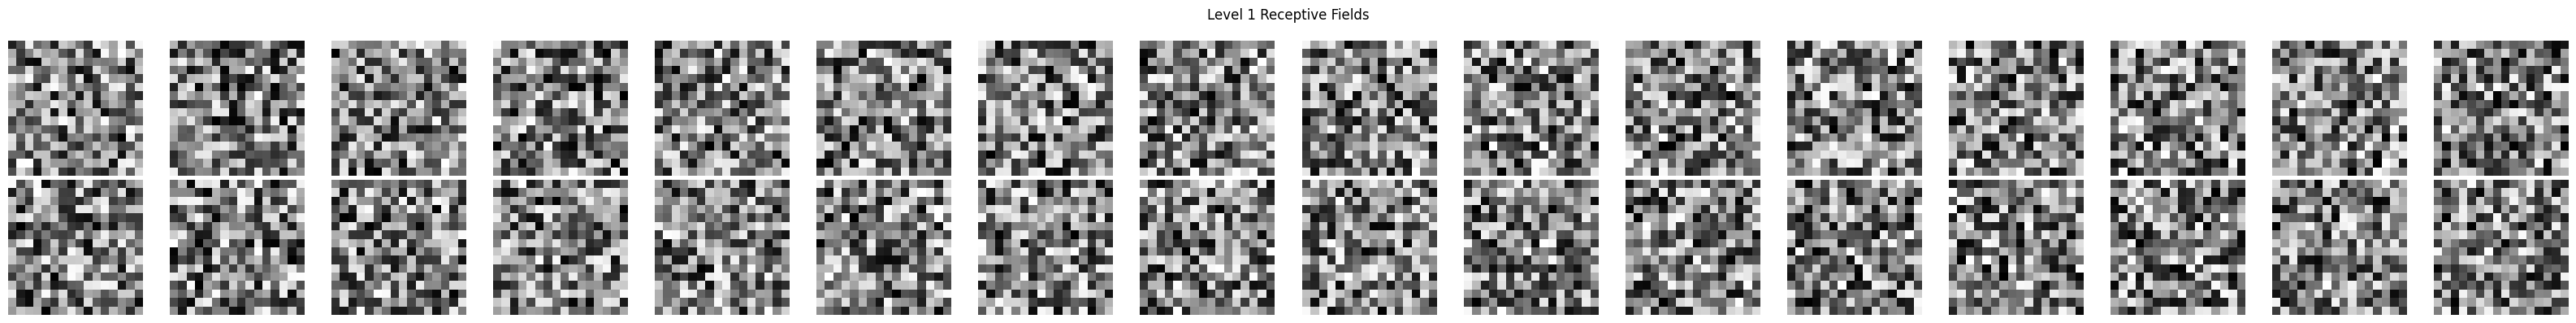

Visualizing the receptive fields for Level 2...
Cannot visualize Level 2 receptive fields as hidden_size1 is not a perfect square.
Plotting the training error...


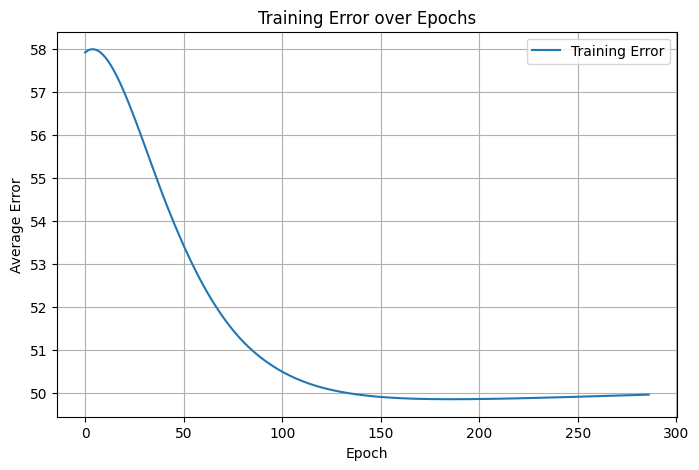

Creating bar images...
Visualizing prediction errors...
Long Bar Prediction Error: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Short Bar Prediction Error: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


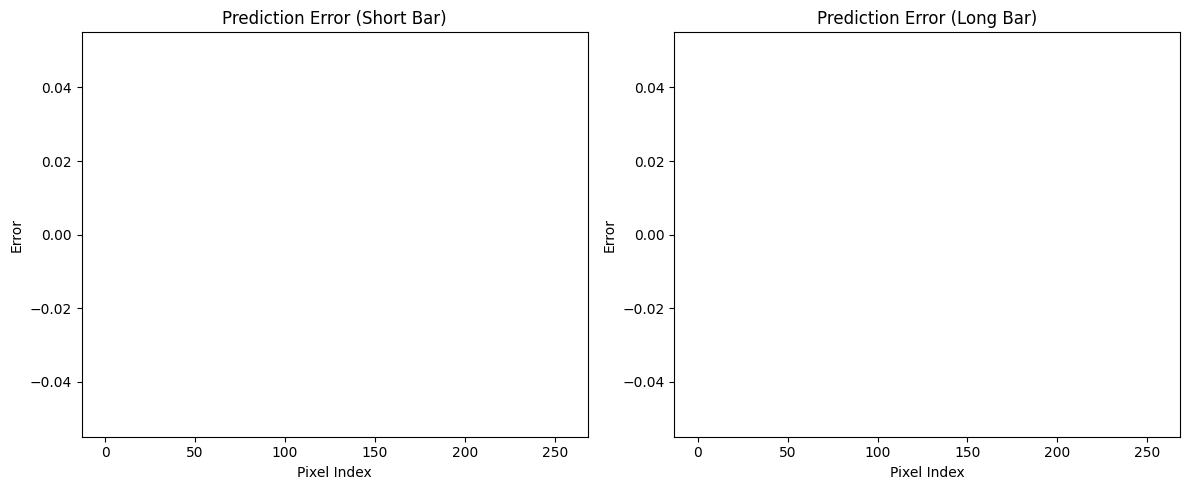

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Activation function (Linear)
def activate(x):
    return x

# Load sample images from local directory
def load_images(image_dir, image_size):
    images = []
    for filename in os.listdir(image_dir):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            try:
                image = Image.open(os.path.join(image_dir, filename)).convert('L')
                image = image.resize((image_size, image_size))
                images.append(np.array(image) / 255.0)  # Normalize pixel values
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
    return np.array(images)

# Create bar images
def create_bar_images(image_size):
    long_bar = np.zeros((image_size, image_size))
    short_bar = np.zeros((image_size, image_size))

    long_bar[image_size // 2, :] = 1  # Horizontal long bar
    short_bar[image_size // 2, image_size // 4:image_size * 3 // 4] = 1  # Horizontal short bar

    return long_bar, short_bar

# Initialize the network with small random weights
def initialize_network(input_size, hidden_size):
    # Using Xavier (Glorot) initialization for better convergence
    limit = np.sqrt(6 / (input_size + hidden_size))
    U = np.random.uniform(-limit, limit, (hidden_size, input_size))
    return U

# Forward pass to get predictions (Linear activation)
def forward(U, x):
    return activate(np.dot(U, x))

# Compute error
def compute_error(I, I_pred):
    return I - I_pred

# Update weights using gradient descent with sparsity and gradient clipping
def update_weights(U, I, I_pred, r, k2, sigma2, lambd, sparse_penalty, clip_value=10.0):
    error = compute_error(I, I_pred)  # Shape: (input_size,)
    # Corrected: Transpose the outer product to match U's shape
    outer_product = np.outer(error, r).T  # Shape: (hidden_size, input_size)
    dU = k2 * (outer_product / sigma2 - lambd * U - sparse_penalty * np.sign(U))  # Shape: (hidden_size, input_size)

    # Gradient Clipping
    norm = np.linalg.norm(dU)
    if norm > clip_value:
        dU = dU * (clip_value / norm)

    U -= dU  # Subtract the gradient
    return U, np.sum(error ** 2)

# Extract overlapping patches from images
def extract_patches(images, patch_size, stride=5):
    patches = []
    for image in images:
        for i in range(0, image.shape[0] - patch_size + 1, stride):
            for j in range(0, image.shape[1] - patch_size + 1, stride):
                patch = image[i:i+patch_size, j:j+patch_size].flatten()
                patches.append(patch)
    return np.array(patches)

# Train the network with separate learning rates and regularization for each level
def train_network(images, patch_size, hidden_size1, hidden_size2, epochs, k2_initial, sigma2, lambd_level1, lambd_level2, sparse_penalty_level1, sparse_penalty_level2, lr_decay_epoch, lr_decay_factor):
    patches = extract_patches(images, patch_size, stride=5)
    input_size = patches.shape[1]

    U1 = initialize_network(input_size, hidden_size1)  # Level 1
    U2 = initialize_network(hidden_size1, hidden_size2)  # Level 2
    errors = []
    k2_level1 = k2_initial
    k2_level2 = k2_initial  # You can set different initial learning rates if desired

    best_error = float('inf')
    patience = 100
    patience_counter = 0

    for epoch in range(epochs):
        epoch_error = 0
        for patch in patches:
            # Level 1
            r1 = forward(U1, patch)  # Shape: (hidden_size1,)

            # Reconstruction at Level 1
            I_pred1 = np.dot(U1.T, r1)  # Shape: (input_size,)
            U1, patch_error1 = update_weights(
                U1, patch, I_pred1, r1, k2_level1, sigma2, lambd_level1, sparse_penalty_level1
            )

            # Level 2
            r2 = forward(U2, r1)  # Shape: (hidden_size2,)

            # Reconstruction at Level 2
            I_pred2 = np.dot(U2.T, r2)  # Shape: (hidden_size1,)
            U2, patch_error2 = update_weights(
                U2, r1, I_pred2, r2, k2_level2, sigma2, lambd_level2, sparse_penalty_level2
            )

            epoch_error += patch_error1 + patch_error2

        avg_error = epoch_error / len(patches)
        errors.append(avg_error)

        # Early Stopping
        if avg_error < best_error:
            best_error = avg_error
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        # Learning rate decay
        if (epoch + 1) % lr_decay_epoch == 0:
            k2_level1 /= lr_decay_factor
            k2_level2 /= lr_decay_factor
            print(f"Decaying learning rates to Level1: {k2_level1}, Level2: {k2_level2}")

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} completed. Avg Error: {avg_error:.6f}")

    return U1, U2, errors

# Visualize receptive fields
def visualize_receptive_fields(U, level, hidden_size, patch_size):
    cols = min(hidden_size, 16)  # Limit number of columns for better visibility
    rows = (hidden_size + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()
    for i in range(hidden_size):
        ax = axes[i]
        try:
            receptive_field = U[i].reshape(patch_size, patch_size)
            ax.imshow(receptive_field, cmap='gray', interpolation='nearest')
        except:
            ax.text(0.5, 0.5, 'N/A', ha='center', va='center', color='red')
        ax.axis('off')
    # Hide any unused subplots
    for i in range(hidden_size, len(axes)):
        axes[i].axis('off')
    plt.suptitle(f'Level {level} Receptive Fields')
    plt.tight_layout()
    plt.show()

# Plot error over epochs
def plot_errors(errors):
    plt.figure(figsize=(8, 5))
    plt.plot(errors, label='Training Error')
    plt.xlabel('Epoch')
    plt.ylabel('Average Error')
    plt.title('Training Error over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_prediction_errors(U1, long_bar, short_bar, patch_size):
    long_bar_patches = extract_patches(np.array([long_bar]), patch_size, stride=patch_size)
    short_bar_patches = extract_patches(np.array([short_bar]), patch_size, stride=patch_size)

    if len(long_bar_patches) == 0 or len(short_bar_patches) == 0:
        print("No patches extracted from bar images. Check patch size and stride.")
        return

    long_bar_patches = long_bar_patches[:1]  # Use the first patch
    short_bar_patches = short_bar_patches[:1]  # Use the first patch

    r1_long = forward(U1, long_bar_patches[0])
    I_pred_long = np.dot(U1.T, r1_long)  # Reconstruction for Long Bar
    long_bar_pred_error = compute_error(long_bar_patches[0], I_pred_long)

    r1_short = forward(U1, short_bar_patches[0])
    I_pred_short = np.dot(U1.T, r1_short)  # Reconstruction for Short Bar
    short_bar_pred_error = compute_error(short_bar_patches[0], I_pred_short)

    # Debugging: Print errors
    print("Long Bar Prediction Error:", long_bar_pred_error[:10])
    print("Short Bar Prediction Error:", short_bar_pred_error[:10])

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].bar(range(len(short_bar_pred_error)), short_bar_pred_error, color='blue')
    axes[0].set_title('Prediction Error (Short Bar)')
    axes[0].set_xlabel('Pixel Index')
    axes[0].set_ylabel('Error')

    axes[1].bar(range(len(long_bar_pred_error)), long_bar_pred_error, color='green')
    axes[1].set_title('Prediction Error (Long Bar)')
    axes[1].set_xlabel('Pixel Index')
    axes[1].set_ylabel('Error')

    plt.tight_layout()
    plt.show()

def main():
    # Configuration
    image_dir = '/content/data'             # Update this path to your local images directory
    image_size = 64                  # Resize images to this size
    patch_size = 16                  # Size of each patch
    hidden_size1 = 32                # Number of hidden neurons in level 1
    hidden_size2 = 128               # Number of hidden neurons in level 2
    epochs = 1000                    # Number of training epochs
    k2_initial = 1e-6                # Initial Learning rate for both levels
    sigma2 = 1                       # Variance
    lambd_level1 = 0.01              # Regularization parameter for Level 1
    lambd_level2 = 0.005             # Regularization parameter for Level 2
    sparse_penalty_level1 = 0.001    # Sparsity penalty for Level 1
    sparse_penalty_level2 = 0.0005   # Sparsity penalty for Level 2
    lr_decay_epoch = 40              # Epochs after which to decay the learning rate
    lr_decay_factor = 1.03           # Factor by which to divide the learning rate

    # Load images
    print("Loading images...")
    images = load_images(image_dir, image_size)
    if len(images) < 5:
        print("Please ensure there are at least 5 images in the directory.")
        return
    print(f"Loaded {len(images)} images.")

    # Train the network
    print("Training the network...")
    U1, U2, errors = train_network(
        images, patch_size, hidden_size1, hidden_size2, epochs,
        k2_initial, sigma2, lambd_level1, lambd_level2,
        sparse_penalty_level1, sparse_penalty_level2,
        lr_decay_epoch, lr_decay_factor
    )

    # Visualize the receptive fields for level 1
    print("Visualizing the receptive fields for Level 1...")
    visualize_receptive_fields(U1, level=1, hidden_size=hidden_size1, patch_size=patch_size)

    # Visualize the receptive fields for level 2
    print("Visualizing the receptive fields for Level 2...")
    # Ensure that patch_size for U2 corresponds to the latent size if needed
    sqrt_hidden_size1 = int(np.sqrt(hidden_size1))
    if sqrt_hidden_size1 ** 2 == hidden_size1:
        visualize_receptive_fields(U2, level=2, hidden_size=hidden_size2, patch_size=sqrt_hidden_size1)
    else:
        print("Cannot visualize Level 2 receptive fields as hidden_size1 is not a perfect square.")

    # Plot the training error over epochs
    print("Plotting the training error...")
    plot_errors(errors)

    # Create bar images for prediction error visualization
    print("Creating bar images...")
    long_bar, short_bar = create_bar_images(image_size)

    # Visualize prediction errors
    print("Visualizing prediction errors...")
    visualize_prediction_errors(U1, long_bar, short_bar, patch_size)

if __name__ == "__main__":
    main()